# Day 08. Exercise 01
# Binary classifier. SVM. Decision tree

## 0. Imports

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn import tree


In [51]:
LABEL_MAP = {0: "working_day", 1: "weekend"}

def add_pred_labels(df: pd.DataFrame, y_pred, col_prefix: str):
    df[col_prefix] = y_pred
    df[f"{col_prefix}_label"] = pd.Series(y_pred, index=df.index).map(LABEL_MAP)

def plot_scatter_with_line(df_plot: pd.DataFrame, hue_col: str, title: str,
                           A: float, B: float, C: float,
                           x_col: str = "am", y_col: str = "pm",
                           line_width: int = 2):
    ax = sns.scatterplot(
        data=df_plot,
        x=x_col,
        y=y_col,
        hue=hue_col,
        alpha=0.85
    )

    x_min, x_max = df_plot[x_col].min(), df_plot[x_col].max()
    xs = np.linspace(x_min, x_max, 200)

    if abs(B) > 1e-12:
        ys = -(A * xs + C) / B
        ax.plot(xs, ys, linewidth=line_width)
    else:
        x0 = -C / A if abs(A) > 1e-12 else 0.0
        ax.axvline(x0, linewidth=line_width)

    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.grid(True)
    plt.show()

def make_grid(df_plot: pd.DataFrame, x_col: str = "am", y_col: str = "pm", grid_step: int = 200):
    x_min, x_max = df_plot[x_col].min(), df_plot[x_col].max()
    y_min, y_max = df_plot[y_col].min(), df_plot[y_col].max()

    xs = np.linspace(x_min, x_max, grid_step)
    ys = np.linspace(y_min, y_max, grid_step)
    XX, YY = np.meshgrid(xs, ys)

    grid = np.c_[XX.ravel(), YY.ravel()]
    return XX, YY, grid

df = pd.read_csv('../data/checker_timestamp.csv')

df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = df["timestamp"].dt.floor("D")
df["ampm"] = (df["timestamp"].dt.hour < 12).map({True: "am", False: "pm"})
df = (
    df.groupby(["date", "ampm"])
      .size()
      .unstack(fill_value=0)
)

df["target"] = np.where(
    df.index.dayofweek.isin([5, 6]),
    "weekend",
    "working_day"
)

daily = df.reset_index()[["date", "am", "pm", "target"]]

X = daily[["am", "pm"]]
y = (daily["target"] == "weekend").astype(int)

## 1. Preprocessing and logreg visualization

Read the file `am_pm.csv` to a dataframe from the previous exercise.

1. Draw a plot where the x-axis is `am`, the y-axis is `pm`, dots are the days, color depends on the target.
2. Add the decision boundary of logistic regression to the plot.
3. Draw the same plot (with the boundary), but the color should depend this time on the predictions.

Now it should be clear for you how the logistic regression works.

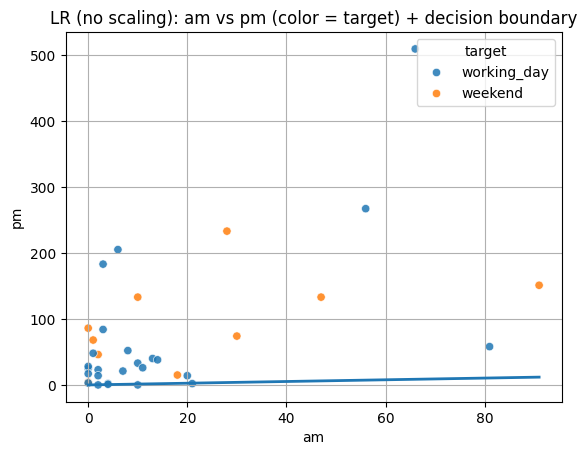

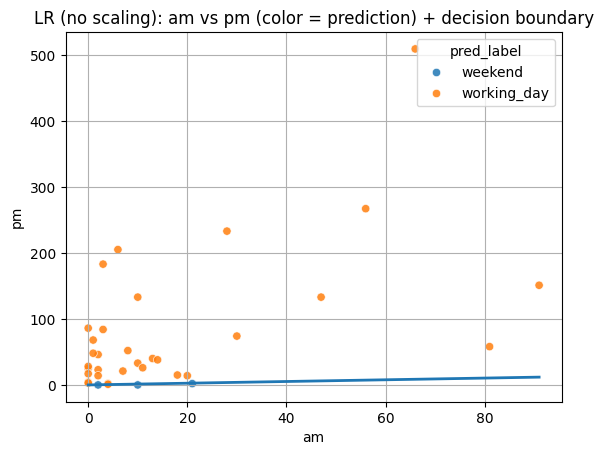

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        35 non-null     datetime64[ns]
 1   am          35 non-null     int64         
 2   pm          35 non-null     int64         
 3   target      35 non-null     object        
 4   pred        35 non-null     int64         
 5   pred_label  35 non-null     object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 1.8+ KB


In [52]:
lr = LogisticRegression(random_state=21, fit_intercept=False, max_iter=1000)
lr.fit(X, y)

add_pred_labels(daily, lr.predict(X), "pred")

w1, w2 = lr.coef_[0]
A, B, C = float(w1), float(w2), 0.0

plot_scatter_with_line(
    daily, "target",
    "LR (no scaling): am vs pm (color = target) + decision boundary",
    A, B, C
)

plot_scatter_with_line(
    daily, "pred_label",
    "LR (no scaling): am vs pm (color = prediction) + decision boundary",
    A, B, C
)

daily.info()


## 2. Standardizing and logreg

Linear models can be sensitive to the scale of your variables. You make it easier for them to find the optimal solution when you scale your features.

1. Apply `StandardScaler` to `X` and train logistic regression again with the same parameters.
2. Calculate `accuracy` for the new model. Did it get better than a naive classifier with the most popular class?
3. Draw the plots that were described above but for the new model.

In [53]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(random_state=21, fit_intercept=False, max_iter=1000))
])

pipe.fit(X, y)

add_pred_labels(daily, pipe.predict(X), "pred_scaled")


In [54]:
acc_lr = accuracy_score(y, daily["pred"])
acc_lr_scaled = accuracy_score(y, daily["pred_scaled"])

most_common_class = int(pd.Series(y).mode()[0])
y_naive = np.full(len(y), most_common_class)
acc_naive = accuracy_score(y, y_naive)

print(f"Accuracy (LR no scaling): {acc_lr}")
print(f"Accuracy (LR scaled):     {acc_lr_scaled}")
print(f"Accuracy (naive baseline): {acc_naive}")

print("\nBetter than naive? (no scaling):", acc_lr > acc_naive)
print("Better than naive? (scaled):    ", acc_lr_scaled > acc_naive)


Accuracy (LR no scaling): 0.6285714285714286
Accuracy (LR scaled):     0.7428571428571429
Accuracy (naive baseline): 0.7142857142857143

Better than naive? (no scaling): False
Better than naive? (scaled):     True


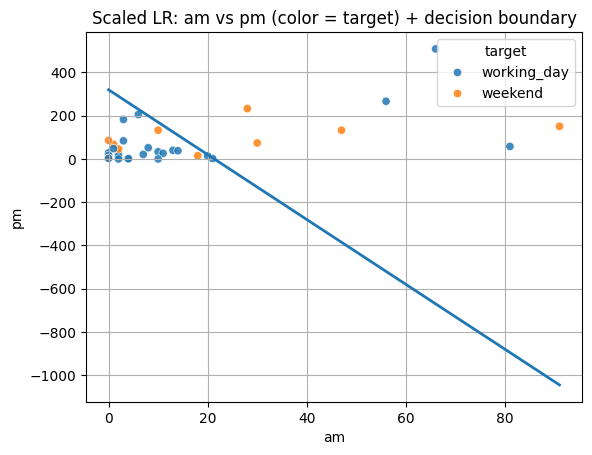

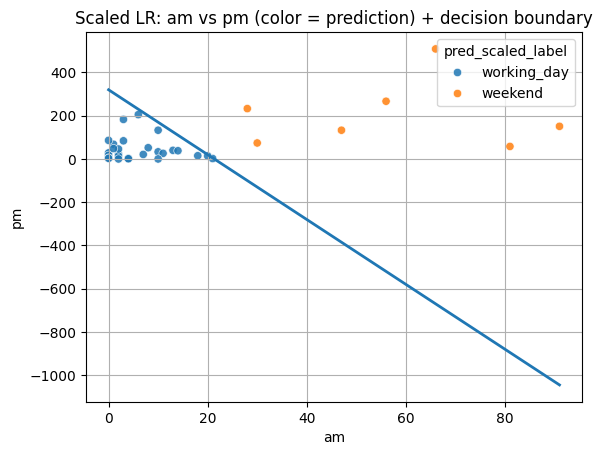

In [55]:
scaler = pipe.named_steps["scaler"]
lr_scaled = pipe.named_steps["lr"]

w1_s, w2_s = lr_scaled.coef_[0]
mu1, mu2 = scaler.mean_
s1, s2 = scaler.scale_

A = float(w1_s / s1)
B = float(w2_s / s2)
C = float(-(w1_s * mu1 / s1 + w2_s * mu2 / s2))

plot_scatter_with_line(
    daily, "target",
    "Scaled LR: am vs pm (color = target) + decision boundary",
    A, B, C
)

plot_scatter_with_line(
    daily, "pred_scaled_label",
    "Scaled LR: am vs pm (color = prediction) + decision boundary",
    A, B, C
)


## 3. SVM

1. Apply `SVC` model to the scaled dataframe using parameters `probability=True`, `random_state=21`.
2. Calculate `accuracy`.
3. Try different kernels, find the best in terms of accuracy.
4. Draw both plots again with the decisions boundary to see how this algorithm works.

In [56]:
kernels = ["linear", "rbf", "poly", "sigmoid"]
results = []

best_kernel = None
best_acc = -1
best_pipe = None

for k in kernels:
    pipe_svc = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel=k, probability=True, random_state=21))
    ])
    pipe_svc.fit(X, y)

    y_pred = pipe_svc.predict(X)
    acc = accuracy_score(y, y_pred)

    results.append({"kernel": k, "accuracy": acc})

    if acc > best_acc:
        best_acc = acc
        best_kernel = k
        best_pipe = pipe_svc

results_df = pd.DataFrame(results).sort_values("accuracy", ascending=False)
print(results_df)
print(f"\nBest kernel: {best_kernel}, accuracy: {best_acc:}")

add_pred_labels(daily, best_pipe.predict(X), "svc_pred")

    kernel  accuracy
1      rbf  0.742857
2     poly  0.742857
0   linear  0.714286
3  sigmoid  0.685714

Best kernel: rbf, accuracy: 0.7428571428571429


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


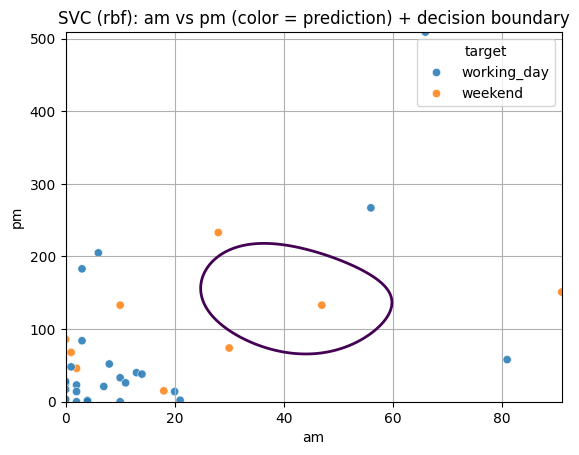

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


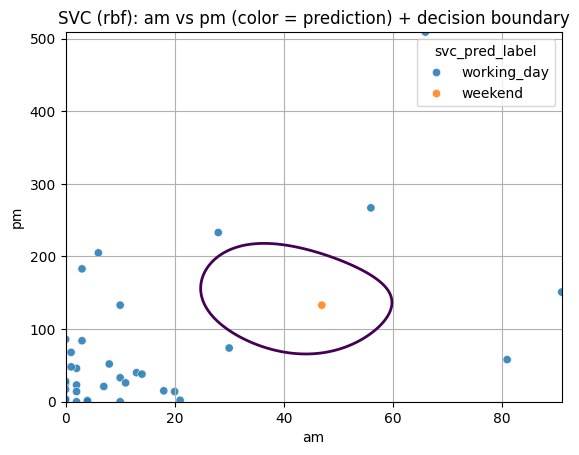

In [57]:
def plot_svc_boundary(df_plot, hue_col, title, pipe_svc, x_col="am", y_col="pm", grid_step=200):
    scaler = pipe_svc.named_steps["scaler"]
    svc = pipe_svc.named_steps["svc"]
    ax = sns.scatterplot(
        data=df_plot,
        x=x_col,
        y=y_col,
        hue=hue_col,
        alpha=0.85
    )
    XX, YY, grid = make_grid(df_plot, x_col=x_col, y_col=y_col, grid_step=grid_step)
    grid_scaled = scaler.transform(grid)
    Z = svc.decision_function(grid_scaled).reshape(XX.shape)
    ax.contour(XX, YY, Z, levels=[0], linewidths=2)

    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.grid(True)
    plt.show()

plot_svc_boundary(
    daily,
    hue_col="target",
    title=f"SVC ({best_kernel}): am vs pm (color = prediction) + decision boundary",
    pipe_svc=best_pipe
)

plot_svc_boundary(
    daily,
    hue_col="svc_pred_label",
    title=f"SVC ({best_kernel}): am vs pm (color = prediction) + decision boundary",
    pipe_svc=best_pipe
)

## 4. Decision tree

1. Apply `DecisionTreeClassifier` to the scaled dataframe using parameters `max_depth=4`, `random_state=42`.
2. Calculate accuracy.
3. Try different values of `max_depth`.
4. Draw both plots again with the decisions boundary to see how this algorithm works.
5. Using method `.plot_tree()` visualize the decision tree itself. It is another way of thinking about how the algorithm works.
6. How many leaves in the visualized tree label days as working days? Put your answer in the markdown cell in the end of the section.

In [ ]:
MAX_DEPTH = 4

pipe_tree = Pipeline([
    ("scaler", StandardScaler()),
    ("dt", DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=42))
])

pipe_tree.fit(X, y)
pred_dt = pipe_tree.predict(X)
acc_dt = accuracy_score(y, pred_dt)

print(f"max_depth={MAX_DEPTH} | accuracy={acc_dt}")

add_pred_labels(daily, pred_dt, "dt_pred")

max_depth=4 | accuracy=0.9428571428571428


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


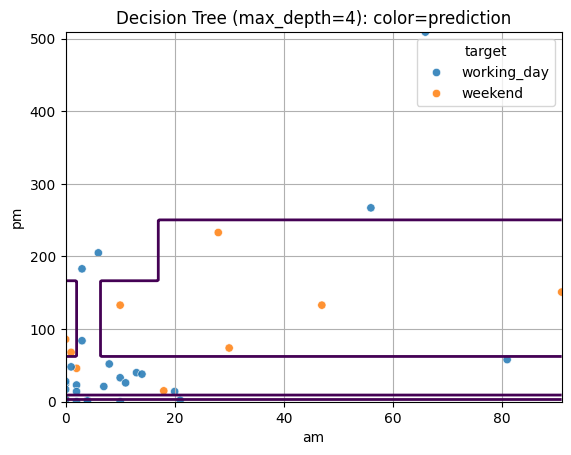

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


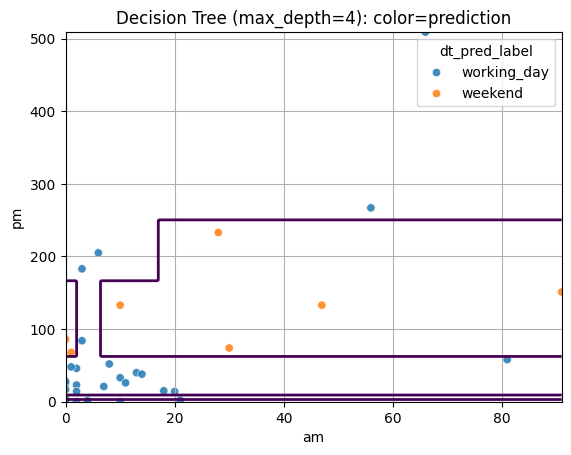

In [59]:
def plot_tree_boundary(df_plot, hue_col, title, pipe_dt, grid_step=250):
    ax = sns.scatterplot(
        data=df_plot,
        x="am",
        y="pm",
        hue=hue_col,
        alpha=0.85
    )

    XX, YY, grid = make_grid(df_plot, x_col="am", y_col="pm", grid_step=grid_step)
    Z = pipe_dt.predict(grid).reshape(XX.shape)

    ax.contour(XX, YY, Z.astype(float), levels=[0.5], linewidths=2)

    ax.set_title(title)
    ax.set_xlabel("am")
    ax.set_ylabel("pm")
    ax.grid(True)
    plt.show()


plot_tree_boundary(
    daily, "target",
    f"Decision Tree (max_depth={MAX_DEPTH}): color=prediction",
    pipe_dt=pipe_tree
)

plot_tree_boundary(
    daily, "dt_pred_label",
    f"Decision Tree (max_depth={MAX_DEPTH}): color=prediction",
    pipe_dt=pipe_tree
)

In [60]:
dt_est = pipe_tree.named_steps["dt"]   # tree estimator from Pipeline
dt_tree = dt_est.tree_

is_leaf = (dt_tree.children_left == -1) & (dt_tree.children_right == -1)
leaf_ids = np.where(is_leaf)[0]

leaf_values = dt_tree.value[leaf_ids, 0, :]
leaf_pred_class = leaf_values.argmax(axis=1)

n_working_leaves = int((leaf_pred_class == 0).sum())
n_weekend_leaves = int((leaf_pred_class == 1).sum())

print("Leaves predicting working_day:", n_working_leaves)
print("Leaves predicting weekend:", n_weekend_leaves)
print("Total leaves:", len(leaf_ids))


Leaves predicting working_day: 6
Leaves predicting weekend: 4
Total leaves: 10


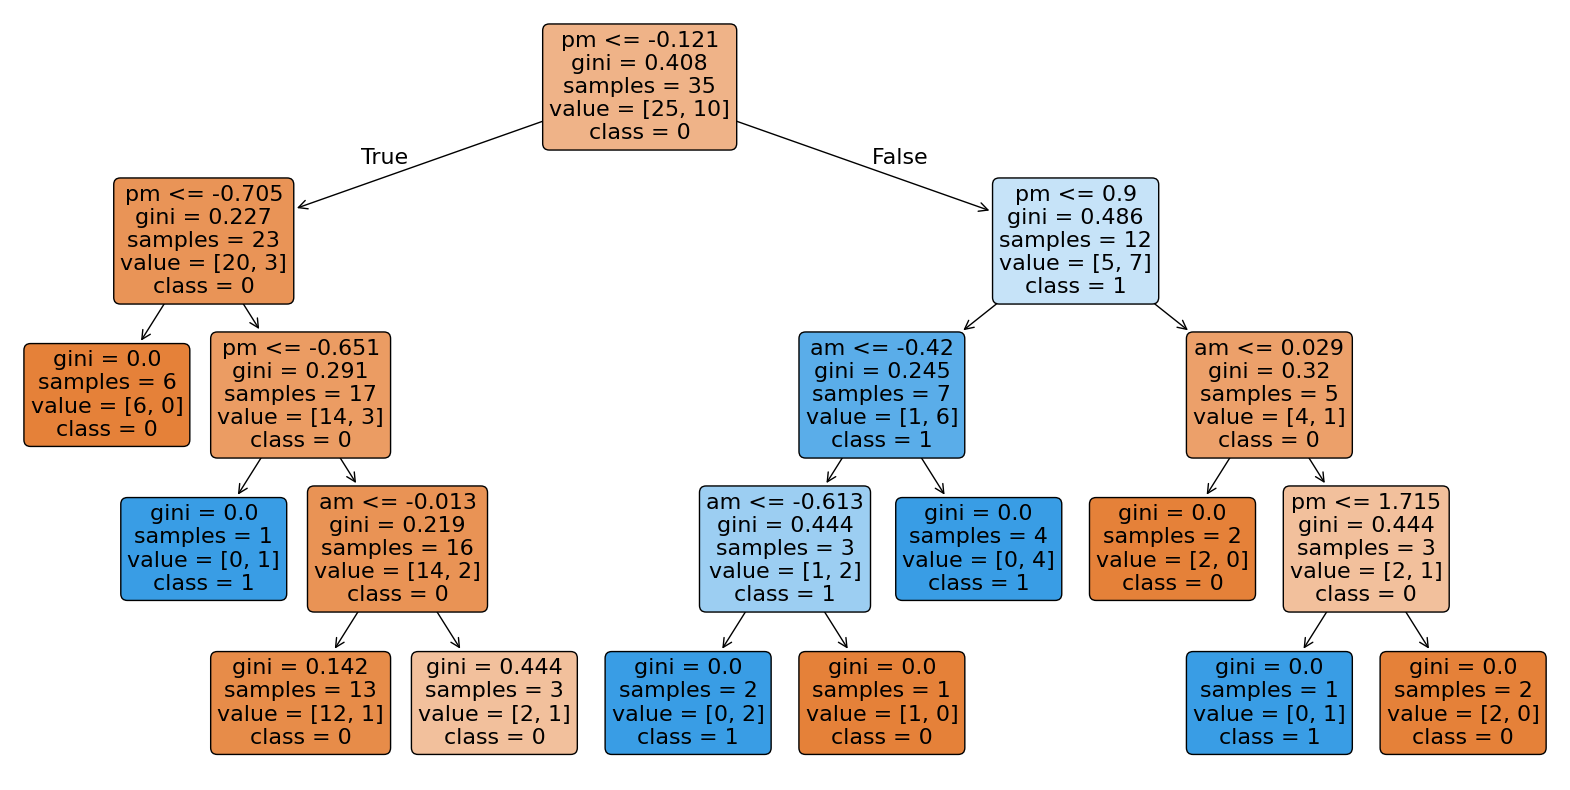

In [61]:
clf_tree = pipe_tree.named_steps["dt"]  

plt.figure(figsize=(20, 10))
tree.plot_tree(
    clf_tree,
    feature_names=X.columns if hasattr(X, "columns") else None,
    class_names=["0", "1"],
    filled=True,
    rounded=True
)
plt.show()